In [106]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import statsmodels.stats.inter_rater as irr

In [97]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


# **Part One: Fitting Models**

In [41]:
X = ha.drop(columns = 'output')
y = ha['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 321, stratify = y)

In [42]:
ct = ColumnTransformer(
  [("dummify",
  OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
  make_column_selector(dtype_include = object)),
  ("standardize",
  StandardScaler(),
  make_column_selector(dtype_include = np.number))],
  remainder = "passthrough"
  ).set_output(transform = "pandas")

### **Q1: KNN**

In [43]:
# TUNE MODEL: KNN
knn_pipeline = Pipeline(
  [('preprocessing', ct),
  ('knn', KNeighborsClassifier())]
  ).set_output(transform = "pandas")
knn_search = GridSearchCV(knn_pipeline, param_grid = {'knn__n_neighbors': range(1, 10 + 1)}, cv = 5, scoring = 'roc_auc')
knn_fitted = knn_search.fit(X, y)
pd.DataFrame(knn_fitted.cv_results_).sort_values('rank_test_score')[['param_knn__n_neighbors', 'mean_test_score', 'rank_test_score']].head(1)

,param_knn__n_neighbors,mean_test_score,rank_test_score
5,6,0.817896,1


The best KNN model has the parameter, k = 6, with a cross-validated ROC/AUC score of 0.817896.

In [55]:
# FIT BEST MODEL: KNN
knn_pipeline = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier(n_neighbors = 6))]
  ).set_output(transform = "pandas")
knn_fitted = knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_fitted.predict(X_test)
y_proba_knn = knn_fitted.predict_proba(X_test)

In [58]:
# FITTED ROC/AUC SCORE + CONFUSION MATRIX: KNN
print(f"FITTED ROC/AUC SCORE:")
print(roc_auc_score(y_test, y_proba_knn[:, 1], average = "weighted"))
print(f"\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_knn))

FITTED ROC/AUC SCORE:
0.7819976076555024

CONFUSION MATRIX:
[[31  7]
 [18 26]]


**INTERPRETATIONS:**

The KNN package doesn't have coefficients, so we'll intepret the estimates with the confusion matrix. The confusion matrix compares our model's predicted y's with the actual y's. It shows that (31 + 26) are correct estimates while (18 + 7) are incorrect. The model's predictions are more accurate than not.

### **Q2: Logistic Regression**

In [87]:
# TUNE MODEL: LOGISTIC REGRESSION
lr_pipeline = Pipeline(
  [('preprocessing', ct),
  ('lr', LogisticRegression())]
  ).set_output(transform = "pandas")
lr_search = GridSearchCV(lr_pipeline, param_grid = {'lr__C': [0.01, 0.1, 1, 10, 100]}, cv = 5, scoring = 'roc_auc')
lr_fitted = lr_search.fit(X, y)
pd.DataFrame(lr_fitted.cv_results_).sort_values('rank_test_score')[['param_lr__C', 'mean_test_score', 'rank_test_score']].head(1)

,param_lr__C,mean_test_score,rank_test_score
0,0.01,0.854643,1


The best logistic regression model has the parameter, alpha = 0.01, with a cross-validated ROC/AUC score of 0.854643.

In [88]:
# FIT BEST MODEL: LOGISTIC REGRESSION
lr_pipeline = Pipeline(
  [('preprocessing', ct),
  ('lr', LogisticRegression(C = 0.01))]
  ).set_output(transform = "pandas")
lr_fitted = lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_fitted.predict(X_test)
y_proba_lr = lr_fitted.predict_proba(X_test)

In [89]:
# FITTED ROC/AUC SCORE + CONFUSION MATRIX: LOGISTIC REGRESSION
print(f"FITTED ROC/AUC SCORE:")
print(roc_auc_score(y_test, y_proba_lr[:, 1], average = "weighted"))
print(f"\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_lr))

FITTED ROC/AUC SCORE:
0.8080143540669856

CONFUSION MATRIX:
[[29  9]
 [ 9 35]]


In [90]:
# COEFFICIENTS
pd.DataFrame(lr_fitted['lr'].coef_, columns = lr_fitted['lr'].feature_names_in_, index = ['coefficient']).T.sort_values('coefficient', ascending = False)

,coefficient
standardize__cp,0.292370
standardize__thalach,0.223063
standardize__restecg,0.086747
standardize__chol,-0.036690
standardize__trtbps,-0.093944
standardize__age,-0.117719
standardize__sex,-0.180491


**INTERPRETATIONS:**

The coefficients can be interpreted as: With each unit increase of the predictor, there is an additional (for positive coefficients) or decreasing (for negative coefficients) of that much for y. For example, with the predictor `thalach`, with each increasing unit of heartrate during exercise, the probability of heart attack risk increases by 0.223063.

We'll intepret the estimates with the confusion matrix. The confusion matrix compares our model's predicted y's with the actual y's. It shows that (25 + 35) are correct estimates while (9 + 9) are incorrect. The model's predictions are more accurate than not.

### **Q3: Decision Tree**

In [66]:
# TUNE MODEL: DT
dt_pipeline = Pipeline(
  [('preprocessing', ct),
  ('dt', DecisionTreeClassifier())]
  ).set_output(transform = "pandas")
dt_search = GridSearchCV(dt_pipeline, param_grid = {'dt__max_depth': range(1, 10 + 1)}, cv = 5, scoring = 'roc_auc')
dt_fitted = dt_search.fit(X, y)
pd.DataFrame(dt_fitted.cv_results_).sort_values('rank_test_score')[['param_dt__max_depth', 'mean_test_score', 'rank_test_score']].head(1)

,param_dt__max_depth,mean_test_score,rank_test_score
1,2,0.772063,1


The best decision tree model has the parameter, max depth = 2, with a cross-validated ROC/AUC score of 0.772063.

In [67]:
# FIT BEST MODEL: DT
dt_pipeline = Pipeline(
  [('preprocessing', ct),
  ('dt', DecisionTreeClassifier(max_depth = 2))]
  ).set_output(transform = "pandas")
dt_fitted = dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_fitted.predict(X_test)
y_proba_dt = dt_fitted.predict_proba(X_test)

In [70]:
# FITTED ROC/AUC SCORE + CONFUSION MATRIX: DT
print(f"FITTED ROC/AUC SCORE:")
print(roc_auc_score(y_test, y_proba_dt[:, 1], average = "weighted"))
print(f"\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_dt))

FITTED ROC/AUC SCORE:
0.7024521531100478

CONFUSION MATRIX:
[[27 11]
 [16 28]]


**INTERPRETATIONS:**

The decision tree package doesn't have coefficients, so we'll intepret the estimates with the confusion matrix. The confusion matrix compares our model's predicted y's with the actual y's. It shows that (27 + 28) are correct estimates while (16 + 11) are incorrect. The model's predictions are more accurate than not.

### **Q4: Interpretation**

In [72]:
pd.DataFrame(dt_fitted['dt'].feature_importances_, index = dt_fitted['dt'].feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

,importance
standardize__cp,0.76130
standardize__thalach,0.12482
standardize__age,0.11388
standardize__sex,0.00000
standardize__trtbps,0.00000
standardize__chol,0.00000
standardize__restecg,0.00000


Based on the decision tree model, it shows that the predictor `cp`, chest pain type, is the most important, followed by `thalach` (maximum heart rate achieved during exercise) and `age` (age of the patient).

### **Q5: ROC Curve**

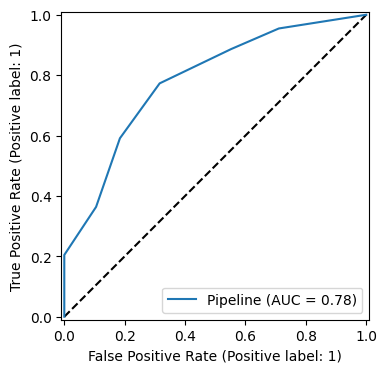

In [80]:
# ROC PLOT: KNN
fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
RocCurveDisplay.from_estimator(knn_fitted,
                               X = X_test,
                               y = y_test,
                               ax = ax);

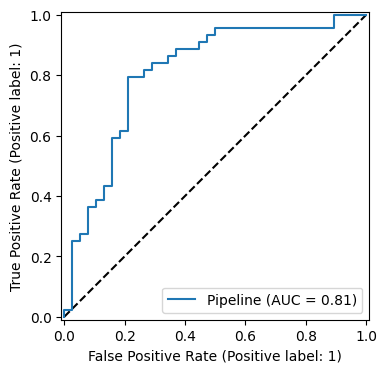

In [91]:
# ROC PLOT: LOGISTIC REGRESSION
fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
RocCurveDisplay.from_estimator(lr_fitted,
                               X = X_test,
                               y = y_test,
                               ax = ax);

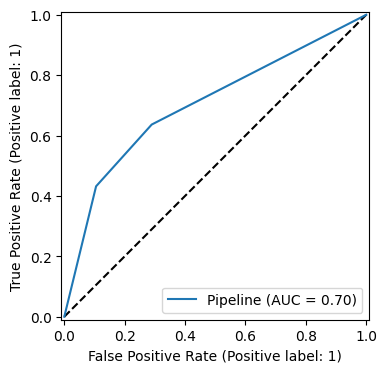

In [81]:
# ROC PLOT: DT
fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
RocCurveDisplay.from_estimator(dt_fitted,
                               X = X_test,
                               y = y_test,
                               ax = ax);

# **Part Two: Metrics**

In [92]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71        38
           1       0.79      0.59      0.68        44

    accuracy                           0.70        82
   macro avg       0.71      0.70      0.69        82
weighted avg       0.72      0.70      0.69        82



**KNN METRICS:**

Sensitivity: 59%

Precision: 79%

Specificity: 82%

In [93]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        38
           1       0.80      0.80      0.80        44

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82



**LOGISTIC REGRESSION METRICS:**

Sensitivity: 80%

Precision: 80%

Specificity: 76%

In [94]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67        38
           1       0.72      0.64      0.67        44

    accuracy                           0.67        82
   macro avg       0.67      0.67      0.67        82
weighted avg       0.68      0.67      0.67        82



**DT METRICS:**

Sensitivity: 64%

Precision: 72%

Specificity: 71%

# **Part Three: Discussion**

**Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.**

a) Sensitivity. We want to minimize false negatives. A higher value is better because we are accurately identifying more positive cases.

b) Logistic regression. It has the highest sensitivity and overall accuracy score.

c) About the same.

**Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.**

a) Precision for Class A. We want to minimize false positives. A higher value is better because more of our predicted positive cases are actually positive.

b) Logistic regression. It has the highest precision for Class A and overall accuracy score.

c) About the same.

**Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.**

a) Decision tree feature importance. It measures the importance of each biological measure (predictors) in influencing heart attack risk (y).

b) Decision tree. It shows feature importance.

c) About the same.



**Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.**

a) Accuracy. Overall accuracy encompasses all true positives, true negatives, false positives, and false negatives.

b) Logistic regression. It has the highest overall accuracy score.

c) About the same.

# **Part Four: Validation**

In [96]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [98]:
X_val = ha_validation.drop(columns = 'output')
y_val = ha_validation['output']

In [100]:
# VALIDATION: KNN
y_pred_knn_val = knn_fitted.predict(X_val)
y_proba_knn_val = knn_fitted.predict_proba(X_val)
print(f"CONFUSION MATRIX:")
print(confusion_matrix(y_val, y_pred_knn_val))
print(f"\nROC/AUC SCORE:")
print(roc_auc_score(y_val, y_proba_knn_val[:, 1], average = "weighted"))
print(f"\nCLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_knn_val))

CONFUSION MATRIX:
[[11  0]
 [ 7 12]]

ROC/AUC SCORE:
0.9186602870813397

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       1.00      0.63      0.77        19

    accuracy                           0.77        30
   macro avg       0.81      0.82      0.77        30
weighted avg       0.86      0.77      0.77        30



In [102]:
# VALIDATION: LOGISTIC REGRESSION
y_pred_lr_val = lr_fitted.predict(X_val)
y_proba_lr_val = lr_fitted.predict_proba(X_val)
print(f"CONFUSION MATRIX:")
print(confusion_matrix(y_val, y_pred_lr_val))
print(f"\nROC/AUC SCORE:")
print(roc_auc_score(y_val, y_proba_lr_val[:, 1], average = "weighted"))
print(f"\nCLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_lr_val))

CONFUSION MATRIX:
[[ 9  2]
 [ 4 15]]

ROC/AUC SCORE:
0.9521531100478469

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.88      0.79      0.83        19

    accuracy                           0.80        30
   macro avg       0.79      0.80      0.79        30
weighted avg       0.81      0.80      0.80        30



In [103]:
# VALIDATION: DT
y_pred_dt_val = dt_fitted.predict(X_val)
y_proba_dt_val = dt_fitted.predict_proba(X_val)
print(f"CONFUSION MATRIX:")
print(confusion_matrix(y_val, y_pred_dt_val))
print(f"\nROC/AUC SCORE:")
print(roc_auc_score(y_val, y_proba_dt_val[:, 1], average = "weighted"))
print(f"\nCLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_dt_val))

CONFUSION MATRIX:
[[10  1]
 [ 4 15]]

ROC/AUC SCORE:
0.8732057416267943

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.94      0.79      0.86        19

    accuracy                           0.83        30
   macro avg       0.83      0.85      0.83        30
weighted avg       0.86      0.83      0.84        30



Yes. Because the validation set is a smaller sample size, the ROC/AUC and accuracy scores are higher now. The order of the models' scores stayed the same (logistic regression highest, KNN middle, and decision tree lowest).

# **Part Five: Cohen’s Kappa**

In [109]:
# KAPPA: KNN
knn_rater = knn_fitted.predict(X)
knn_conf_matrix = confusion_matrix(y, knn_rater)
knn_kappa = irr.cohens_kappa(knn_conf_matrix)
print(f"KNN Kappa: {knn_kappa}")

KNN Kappa:                   Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.6195
              ASE                       0.0473
              95% Lower Conf Limit      0.5268
              95% Upper Conf Limit      0.7122

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0603
              Z                         10.2760
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000



In [111]:
# KAPPA: LOGISTIC REGRESSION
lr_rater = lr_fitted.predict(X)
lr_conf_matrix = confusion_matrix(y, lr_rater)
lr_kappa = irr.cohens_kappa(lr_conf_matrix)
print(f"Logistic Regression Kappa: {lr_kappa}")

Logistic Regression Kappa:                   Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.5776
              ASE                       0.0495
              95% Lower Conf Limit      0.4806
              95% Upper Conf Limit      0.6745

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0602
              Z                         9.5876
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000



In [112]:
# KAPPA: DT
dt_rater = dt_fitted.predict(X)
dt_conf_matrix = confusion_matrix(y, dt_rater)
dt_kappa = irr.cohens_kappa(dt_conf_matrix)
print(f"DT Kappa: {dt_kappa}")

DT Kappa:                   Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.5355
              ASE                       0.0513
              95% Lower Conf Limit      0.4350
              95% Upper Conf Limit      0.6360

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0605
              Z                         8.8501
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000



Cohen's Kappa is a measure of agreement between two raters. In this case, we measure how much in agreement is our model's predictions vs. actual y. We might prefer Cohen's Kappa if the dataset is small or biased. The conclusions do change. Originally, the order from best to worst model was: logistic regression > KNN > decision tree. Now it's: KNN > logistic regression > decision tree. This might be because logistic regression and decision trees rely on set values but KNN relies on values of the sample, so fundamentally, KNN predictions would agree with actual y's more often.